# Regression

## Objectives

*   Fit and evaluate a regression model to predict tenure levels for a prospect that will likely churn


## Inputs

* outputs/datasets/collection/bank-customer-churn.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict tenure
* labels map
* Feature Importance Plot



---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/home/joplar/banking-churnometer'

---

# Load Data

In [69]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/bank-customer-churn.csv")
      .query("Exited == 1")  # subset churned customer
      .drop(labels=['CustomerId', 'RowNumber', 'Surname','Exited'], axis=1)
      # variables we will not need for this project
      # we will not need Tenure since it has only 1
      )

cat_vars = ['Geography','Gender','HasCrCard','IsActiveMember','NumOfProducts']
df[cat_vars] = df[cat_vars].astype(object)

print(df.shape)
df.head(3)


(2037, 10)


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71


# MP Pipeline: Regressor

## Create ML pipeline

In [70]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor



def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("boxcox", vt.BoxCoxTransformer(variables=['Age'])),
        ("Winsorizer", Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables=['Age','CreditScore'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary', variables=['Gender','Geography'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


Custom Class for hyperparameter optimisation

In [71]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


## Split Train Test Set

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Tenure'], axis=1),
    df['Tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1629, 9) (1629,) 
* Test set: (408, 9) (408,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [73]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [74]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/joplar/.pyenv/versions/3.8.18/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be remove

Check results

In [75]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
0,LinearRegression,-0.025913,-0.002862,0.00832,0.012205
4,AdaBoostRegressor,-0.01481,-0.006595,-0.00145,0.004811
2,RandomForestRegressor,-0.16992,-0.064872,-0.008572,0.057763
5,GradientBoostingRegressor,-0.120401,-0.067349,-0.041627,0.028211
3,ExtraTreesRegressor,-0.210262,-0.128283,-0.053853,0.06198
6,XGBRegressor,-0.326052,-0.22533,-0.143937,0.066462
1,DecisionTreeRegressor,-1.1895,-0.986395,-0.806342,0.146208


### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [76]:
models_search = {
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "DecisionTreeRegressor": {
           'model__max_depth': [3, 5, 7, 10],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
    }
}

Extensive GridSearch CV

In [77]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


Check results

In [78]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split
8,DecisionTreeRegressor,-0.06917,-0.038647,-0.025572,0.016428,3,4,10
6,DecisionTreeRegressor,-0.06917,-0.040524,-0.025572,0.017283,3,4,2
7,DecisionTreeRegressor,-0.06917,-0.040524,-0.025572,0.017283,3,4,5
2,DecisionTreeRegressor,-0.073703,-0.042185,-0.026943,0.016783,3,1,10
5,DecisionTreeRegressor,-0.073703,-0.042185,-0.026943,0.016783,3,2,10
4,DecisionTreeRegressor,-0.073703,-0.044298,-0.026943,0.017353,3,2,5
1,DecisionTreeRegressor,-0.073703,-0.044298,-0.026943,0.017353,3,1,5
0,DecisionTreeRegressor,-0.073703,-0.044685,-0.028879,0.016979,3,1,2
3,DecisionTreeRegressor,-0.073703,-0.044804,-0.029183,0.01687,3,2,2
14,DecisionTreeRegressor,-0.094297,-0.057826,-0.02147,0.024134,5,2,10


Check the best model

In [82]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'DecisionTreeRegressor'

Parameters for best model

In [83]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 3,
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 10}

Define the best regressor, based on search

In [63]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('boxcox', BoxCoxTransformer(variables=['Age'])),
                ('Winsorizer',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'CreditScore'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Gender', 'Geography'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['CreditScore', 'Geography',
                                                     'Gender', 'Age', 'Balance',
                                                     'EstimatedSalary'])),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel

## Assess feature importance

* These are the 4 most important features in descending order. The model was trained on them: 
['EstimatedSalary', 'Age', 'CreditScore', 'Balance']


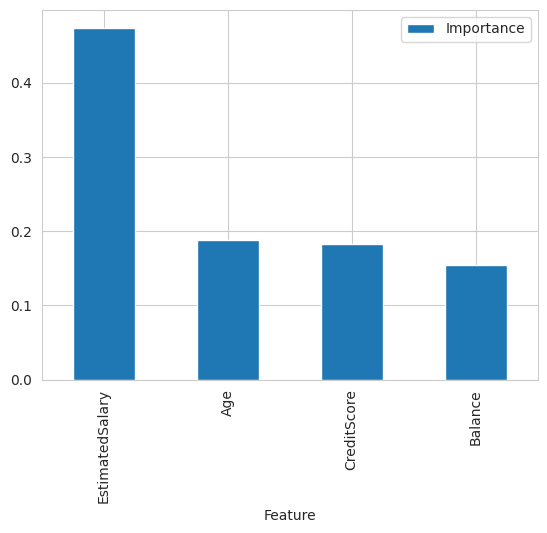

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate on Train and Test Sets

In [85]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: -1.935
Mean Absolute Error: 4.205
Mean Squared Error: 25.63
Root Mean Squared Error: 5.063


* Test Set
R2 Score: -2.215
Mean Absolute Error: 4.291
Mean Squared Error: 26.179
Root Mean Squared Error: 5.117




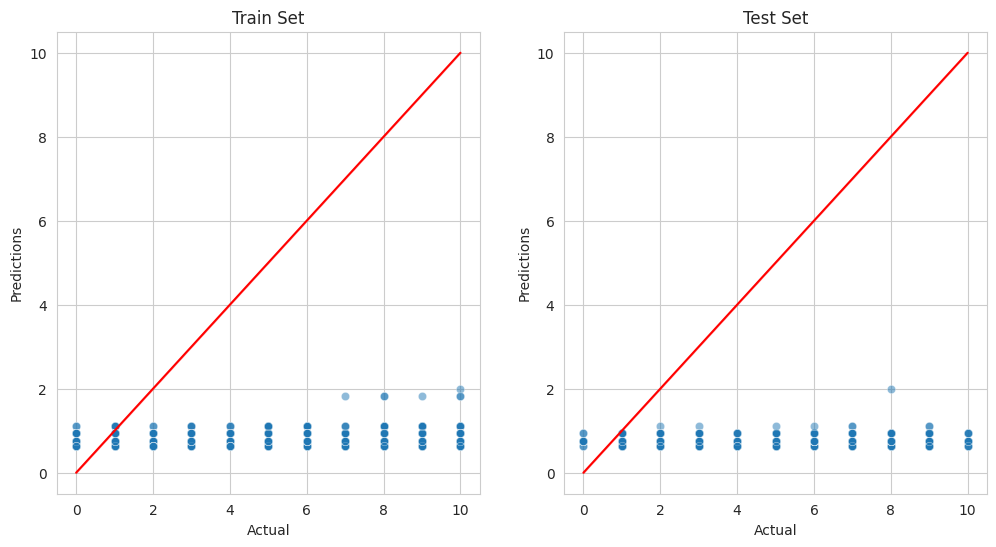

In [86]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [87]:
pipeline = PipelineOptimization(model=LinearRegression())
pipeline_pca = Pipeline(pipeline.steps[:3])
df_pca = pipeline_pca.fit_transform(df.drop(['Tenure'], axis=1))

print(df_pca.shape,'\n', type(df_pca))

(2037, 9) 
 <class 'pandas.core.frame.DataFrame'>


Apply PCA separately to the scaled data

* The 9 components explain 100.0% of the data 



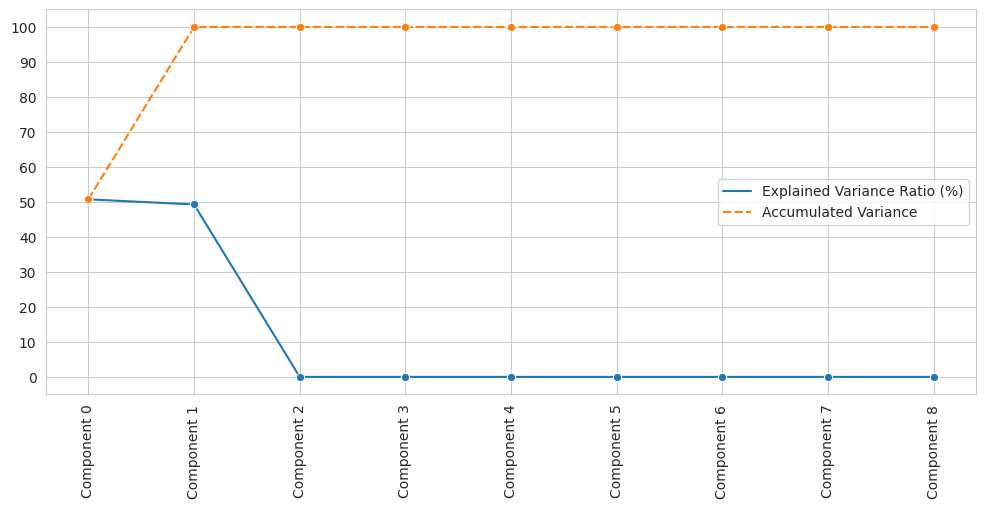

In [88]:
import numpy as np
from sklearn.decomposition import PCA

n_components = 9


def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


In [ ]:
n_components = 7
pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [ ]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Gender', 'Geography'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base


## Grid Search CV – Sklearn

In [ ]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

### Use standard hyperparameters to find the most suitable model.

In [ ]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [ ]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [ ]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

Extensive GridSearch CV

In [ ]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model

In [ ]:
grid_search_pipelines[best_model].best_params_

Define the best regressor

In [ ]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

## Evaluate Regressor on Train and Tests Sets

In [ ]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

In [ ]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=3, variables=['Tenure'])  # we will try q as 2, and 3
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='tenure')
plt.show()

In [ ]:
df_clf.head(3)

## Rewrite ML Pipeline for Modelling

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Gender', 'Geography'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


## Load algorithms for classification

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['tenure'], axis=1),
    df_clf['tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [ ]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)

Check results

In [ ]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [ ]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}


Extensive GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary


Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Parameters for best model
* We are saving this content for later

In [ ]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

## Assess feature importance

We can assess feature importance for this model with `.feature_importances_`

In [ ]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

Custom Function

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)


List that relates the classes and tenure interval

In [ ]:
disc.binner_dict_['Tenure']

We can create manually

In [ ]:
label_map = ['<4.0', '4.0 to 20.0','+20.0']
label_map

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

# Which pipeline to choose?

We fitted 3 pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
* Class 1 (4 to 20 months) has weak performance.

In [ ]:
pipeline_clf

# Refit pipeline with best features

## Rewrite Pipeline

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Contract', 'PaymentMethod'])),

        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base


## Split Train Test Set, only with best features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['tenure'], axis=1),
    df_clf['tenure'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


Subset Best Features

In [ ]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [ ]:
models_search

And the best parameters from the previous GridCV search

In [ ]:
best_parameters

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [ ]:
params_search = {'AdaBoostClassifier':  {
    'model__learning_rate': [0.001],   # the value should be in []
    'model__n_estimators': [50]       # the value should be in []
}
}
params_search

GridSearch CV

In [ ]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)


Check results

In [ ]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

Check the best model

In [ ]:
best_model = grid_search_summary.iloc[0,0]
best_model

Define the best clf pipeline

In [ ]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

## Assess feature importance

In [ ]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


## Evaluate Classifier on Train and Test Sets

In [ ]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [ ]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_tenure/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [ ]:
X_train.head()

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

## Test Set: features and target

In [ ]:
X_test.head()

In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

## Modelling pipeline

ML pipeline for predicting tenure

In [ ]:
pipeline_clf

In [ ]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

## List  mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [ ]:
label_map

In [ ]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

## Feature importance plot

In [ ]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

Good job! Clear cell's outputs, push to the repo using git commands and move on to the next notebook

---